In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle

categories = [
    "mathematician",
    "painter"
]
DATA_FILE = "./clean_data.csv"

### Class distribution

In [2]:
df = pd.read_csv(DATA_FILE, header = 0)
df.groupby("label")["label"].count()

label
0    460
1    185
Name: label, dtype: int64

Classes are unbalanced, we need to undersample our data to ensure better generalisation of our model

In [3]:
def undersample(df):
    maths = df[df['label']==0]
    paints = df[df['label']==1]
    if maths.shape[0] > paints.shape[0]:
        maths = maths.sample(n=len(paints), random_state=101)
    else:
        paints = paints.sample(n=len(maths), random_state=101)
    df = pd.concat([maths,paints],axis=0)
    return df

In [4]:
def load_dataset(data, undersam=True):
    """Loads, balances the classes dist. and vectorize the articles dataset."""
    df = pd.read_csv(data, header = 0)
    if undersam:
        df = undersample(df)
    df = shuffle(df)
    X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != "label"], df["label"], test_size=0.20, random_state=42, shuffle=True)
    target_names = df["label"].unique()
    return X_train, X_test, y_train, y_test, target_names

### Hyperparameters tuning

We define a universal estimator object that can take any classifier as an input \
to make hyperparamters search easier (i.e the classifier will be a parameter as any other hyperparameters tuning)

In [5]:
from sklearn.base import BaseEstimator

class UniversalEstimator(BaseEstimator):
    def __init__(
        self, 
        estimator = MultinomialNB(),
    ):
        """
        A Custom BaseEstimator, universal to all sklearn classifiers
        :param estimator: sklearn classifier object
        """ 

        self.estimator = estimator
    
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)
    
    def confusion_matrix(self, pred, y_test, target_names):
        fig, ax = plt.subplots(figsize=(10, 5))
        ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
        ax.xaxis.set_ticklabels(target_names)
        ax.yaxis.set_ticklabels(target_names)
        _ = ax.set_title(
            f"Confusion Matrix for {self.__class__.__name__}\non the original documents"
        )

In [6]:
def save_rank_models(grid, proc, model):
    """ Saves best model from the grid hyperparameter tuning """
    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_F1"])
    results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
    ).rename_axis("kernel")
    grid_name = "results/results_{}_{}.csv".format(str(proc), str(model))
    results_df["process"] = str(proc)
    results_df["model"] = str(model)
    results_df.to_csv(grid_name)
    return results_df[["params", "rank_test_F1", "mean_test_F1", "std_test_F1"]]

In [7]:
# Setting hyparameters search space 
scoring = {
           "F1": "f1",
           "Accuracy":"accuracy",
           "Recall": "recall"
           }
model_params = {
    "rf" : [
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__n_estimators': [200, 500],
        'clf__estimator__max_depth' : [4,5,6,7,8],
        'clf__estimator__max_features': ['auto', 'sqrt', 'log2'],
        'clf__estimator__criterion': ['gini', 'entropy'],
    }
],
"mnb" : [
    {
        'clf__estimator': [MultinomialNB()],
        'clf__estimator__alpha': (1e-2, 1e-3, 1e-1),
    }
]
}

In [8]:
pipeline_tf = Pipeline([
    ("vect", TfidfVectorizer(sublinear_tf=True, min_df=5)),
    ('clf', UniversalEstimator())
])

Test combinations on full data size with different preprocessings, later we will select best models and rerun on data size, text proc and compare it affects performance

In [9]:
text_processing = ["norm_text", "text", "norm_stops_text"]
df = pd.read_csv(DATA_FILE, header = 0)
df = undersample(df)
df = shuffle(df)

# Iterate over different types of text preprocessing
for process in text_processing:
    X_train = df[process]
    y_train = df["label"]
    for model in model_params :
        grid = GridSearchCV(pipeline_tf, model_params[model],
                scoring=scoring, refit="F1", cv=5, n_jobs=12)
        grid.fit(X_train, y_train)
        save_rank_models(grid, process, model)
        

### Performance analysis

In [33]:
import re, glob
cats = ["rf", "mnb"]
chain = "|".join(cats)
regex = "(.*)_({})".format(chain)
r = re.compile(regex)
namecat = [ [f, r.match(f).group(2)]  for f in glob.glob1("./results", "*.csv")]

In [34]:
# Merge all result files by classifier
forest_res = (pd.read_csv("./results/"+f) for f in glob.glob1("./results", "*.csv") if r.match(f).group(2)=="rf")
bayes_res = (pd.read_csv("./results/"+f) for f in glob.glob1("./results", "*.csv") if r.match(f).group(2)=="mnb")

In [35]:
rf_df = pd.concat(forest_res, ignore_index=True) 
by_df = pd.concat(bayes_res, ignore_index=True) 

In [36]:
# Select among all hyperparamter configuration, the 3 best among the 3 types of preprocessing
best_rf = rf_df[rf_df["rank_test_F1"]==1][["mean_test_F1", "std_test_F1","process", "params"]]
best_rf

,mean_test_F1,std_test_F1,process,params
0,0.984468,0.015356,text,{'clf__estimator': RandomForestClassifier(crit...
1,0.984468,0.015356,text,{'clf__estimator': RandomForestClassifier(crit...
60,0.986999,0.014612,norm_stops_text,{'clf__estimator': RandomForestClassifier(max_...
61,0.986999,0.014612,norm_stops_text,{'clf__estimator': RandomForestClassifier(max_...
120,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...
121,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...
122,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...
123,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...
124,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...
125,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...


In [37]:
best_rf["params"].to_list()

["{'clf__estimator': RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200), 'clf__estimator__criterion': 'entropy', 'clf__estimator__max_depth': 6, 'clf__estimator__max_features': 'auto', 'clf__estimator__n_estimators': 200}",
 "{'clf__estimator': RandomForestClassifier(criterion='entropy', max_depth=6, n_estimators=200), 'clf__estimator__criterion': 'entropy', 'clf__estimator__max_depth': 8, 'clf__estimator__max_features': 'auto', 'clf__estimator__n_estimators': 200}",
 "{'clf__estimator': RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=200), 'clf__estimator__criterion': 'entropy', 'clf__estimator__max_depth': 8, 'clf__estimator__max_features': 'auto', 'clf__estimator__n_estimators': 500}",
 "{'clf__estimator': RandomForestClassifier(max_depth=8, max_features='sqrt', n_estimators=200), 'clf__estimator__criterion': 'gini', 'clf__estimator__max_depth': 8, 'clf__estimator__max_features': 'sqrt', 'clf__estimator__n_estimators': 200}",
 "{'clf__es

We selected the best RandomForestClassifier among the 3 possible preprocessings. We notice that there is no significant change in fscore btw the 3

In [38]:
best_mnb = by_df[by_df["rank_test_F1"]==1][["mean_test_F1", "std_test_F1","process", "params"]]
best_mnb

,mean_test_F1,std_test_F1,process,params
0,0.978782,0.019235,text,"{'clf__estimator': MultinomialNB(alpha=0.1), '..."
3,0.981134,0.019492,norm_stops_text,"{'clf__estimator': MultinomialNB(alpha=0.1), '..."
6,0.983603,0.020893,norm_text,"{'clf__estimator': MultinomialNB(alpha=0.1), '..."


For the Multinomial Naive Bayes, we notice that normalisation helped improve the performance

We run a test phase on the 3 best models configuration for each of Random Forest and MultinomialNB

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

X_train, X_test, y_train, y_test, target_names = load_dataset(DATA_FILE)
scoring = {
           "accuracy":"accuracy",
           "F1": "f1"
           }

def test(res_df):
    mats = []
    fscores = []
    for _, row in res_df.iterrows():
            p = eval(row.params)
            datatype = row.process
            prm = [ { pr:[p[pr]] for pr in p } ]
            pipeline_tf = Pipeline([
                ("vect", TfidfVectorizer(sublinear_tf=True, min_df=15)),
                ('clf', UniversalEstimator())
            ])               
            # we use gridsearch here with one possible combination because it implements kfold training
            grid = GridSearchCV(pipeline_tf, prm, cv=5, scoring=scoring, refit="F1", n_jobs=12)
            grid.fit(X_train[datatype], y_train)
            pred = grid.best_estimator_.predict(X_test[datatype])
            precision, recall, fscore, _ = precision_recall_fscore_support(y_test, pred, average='macro')
            fscores.append(fscore)
            mats.append(confusion_matrix(y_test, pred))
    res_df["fscore"] = fscores
    res_df["matrix"] = mats
    res_df["preds"] = str(list(pred))
    return res_df

rforests = test(best_rf)
    

In [53]:
multi_bayes = test(best_mnb)

In [54]:
pd.concat([rforests, multi_bayes]).sort_values(by=["fscore"], ascending=False).head(5)

,mean_test_F1,std_test_F1,process,params,fscore,matrix,preds
0,0.984468,0.015356,text,{'clf__estimator': RandomForestClassifier(crit...,0.972243,"[[30, 1], [1, 42]]","[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ..."
127,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...,0.972243,"[[30, 1], [1, 42]]","[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ..."
3,0.981134,0.019492,norm_stops_text,"{'clf__estimator': MultinomialNB(alpha=0.1), '...",0.972243,"[[30, 1], [1, 42]]","[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ..."
0,0.978782,0.019235,text,"{'clf__estimator': MultinomialNB(alpha=0.1), '...",0.972243,"[[30, 1], [1, 42]]","[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ..."
133,0.986999,0.014612,norm_text,{'clf__estimator': RandomForestClassifier(max_...,0.972243,"[[30, 1], [1, 42]]","[1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ..."


We notice that Multinomial slighlt outperforms RandomForest

We select the best model among them

In [55]:
best_model = pd.concat([rforests, multi_bayes]).sort_values(by=["fscore"], ascending=False).head(5).iloc[0]

In [56]:
best_model

mean_test_F1                                             0.984468
std_test_F1                                              0.015356
process                                                      text
params          {'clf__estimator': RandomForestClassifier(crit...
fscore                                                   0.972243
matrix                                         [[30, 1], [1, 42]]
preds           [1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, ...
Name: 0, dtype: object

### Data size effect on performance

In [57]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

We evaluate the performance of our model when trained on different sizes of data

In [58]:

data_size = [.25, .5, 1]
X_train = X_train["norm_text"]
results = []
for size in data_size:
    p = eval(best_model["params"])
    datatype = best_model["process"]
    prm = [ { pr:[p[pr]] for pr in p } ]
    full_data = pd.DataFrame()
    full_data = pd.concat([X_train, y_train], axis=1)
    full_data = full_data.sample(frac=size)
    print(full_data.shape)
    y = full_data["label"]
    X = full_data["norm_text"]
    pipeline_tf = Pipeline([
        ("vect", TfidfVectorizer(sublinear_tf=True, min_df=15)),
        ('clf', UniversalEstimator())
    ])
    pipeline_tf.fit(X, y)
    pred = pipeline_tf.predict(X_test[datatype])
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, pred, average='macro')
    print(fscore)
    results.append({"size" : size, "precision": precision, "recall": recall, "fscore": fscore})

data_tests = pd.DataFrame(results)

(74, 2)
0.9722430607651913
(148, 2)
0.9722430607651913
(296, 2)
0.9722430607651913


In [59]:
data_tests

,size,precision,recall,fscore
0,0.25,0.972243,0.972243,0.972243
1,0.50,0.972243,0.972243,0.972243
2,1.00,0.972243,0.972243,0.972243


<AxesSubplot:title={'center':'Grouped Bar Graph of performance metrics on different data sizes'}, xlabel='size'>

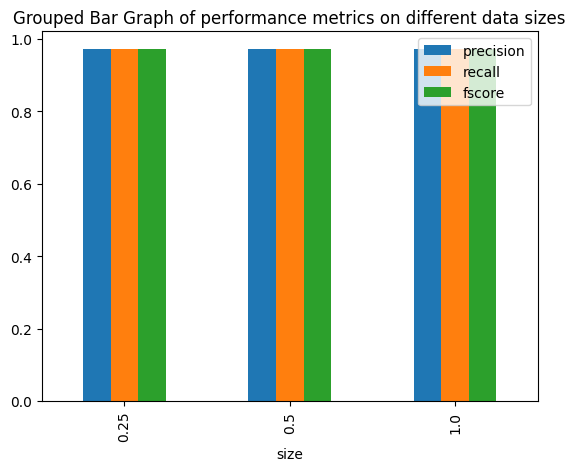

In [60]:
data_tests.plot(x='size',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph of performance metrics on different data sizes')

### Explainability

In [70]:

top_models = pd.concat([rforests, multi_bayes]).sort_values(by=["fscore"], ascending=False).head(3)

for index, model in top_models.iterrows():
    predictions = eval(model["preds"])
    X_test = X_test.reset_index(drop=True)
    fp = [i for i in range(len(predictions)) if list(y_test)[i] == 0 and predictions[i] == 1]
    fn = [i for i in range(len(predictions)) if list(y_test)[i] == 1 and predictions[i] == 0]
    for m in fn: print(X_test["text"].iloc[m])
    for m in fp: print(X_test["text"].iloc[m])
    not_painter = X_test.loc[fp,:]
    not_mathematician = X_test.loc[fn,:]


Akimitsu (written: 右光, 彬光, 昭光 or 顕光) is a masculine Japanese given name. Notable people with the name include: Fujiwara no Akimitsu (藤原 顕光, 944–1021), Japanese noble Ishikawa Akimitsu (石川 昭光, 1550–1622), Japanese samurai Akimitsu Itoh (伊東 昭光, born 1963), Japanese baseball pitcher Akimitsu Takagi (高木 彬光, 1920–1995), Japanese writer Akimitsu Takase (高瀬 右光, born 1970), Japanese voice actor
General Sir John Miller Adye (1 November 1819 – 26 August 1900) was a British soldier and amateur artist. Adye was the son of Major James P. Adye, born at Sevenoaks, Kent, on 1 November 1819. He studied at the Royal Military Academy, Woolwich, entered the Royal Artillery in 1836, was promoted to captain in 1846, and served throughout the Crimean War as brigade-major and assistant adjutant-general of artillery (awarded CB, brevets of major and lieutenant-colonel).In the Indian rebellion of 1857 he served on the staff in a similar capacity. Promoted brevet-colonel in 1860, he was specially employed in 186

All 3 models misclassify the same articles, let's have a closer look why?

We notice among misclassified texts :

- 1 false positive : 
  - Misclassified because of an issue with data extraction, the scraped page by wikipedia library is of General Sir John Miller Adye (An artist) and should have been of John Adye (a methematician)

- 1 false negative:
  - Also misclassified because of a data extraction issue, the wikipedia library is returned the page content of the given name Akimitsu
  